In [ ]:
#Copy Dataset From Google Drive
!sudo cp -v -r "/content/drive/MyDrive/Colab Notebooks/CityScapes/CamVid" "/content"

In [2]:
#importing packages
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

In [3]:
#Function to get the path of the dataset into DataFrame
def return_file_names_df(root_dir):
  image_path=[]
  mask=[]
  for folder in sorted(os.listdir('CamVid/')):
    if folder == 'train':
     for files in sorted(os.listdir('CamVid/'+root_dir+'/')):
       image_path.append('CamVid/'+root_dir+'/'+files)
    if folder == 'train'+'_labels':
      for files in sorted(os.listdir('CamVid/'+root_dir+'_labels'+'/')):
        mask.append('CamVid/'+root_dir+'_labels'+'/'+files)
  data=pd.DataFrame({'image':image_path,'mask':mask})

  return data

In [4]:
# Train and Test Data
train_data = return_file_names_df('train')
test_data= return_file_names_df('val')

In [5]:
print(train_data.shape)
print(test_data.shape)

(601, 2)
(100, 2)


In [7]:
#Read an image from train dataset
image = cv2.imread(train_data.image[100], cv2.IMREAD_UNCHANGED) 
image = cv2.resize(image,(512,512),interpolation=cv2.INTER_NEAREST)
image = image/255

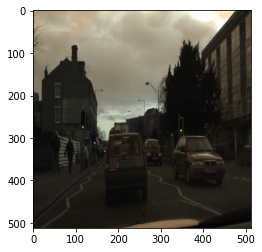

In [9]:
#Plot the image
plt.imshow(image)

In [10]:
#Read the classes files
classes = pd.read_csv('CamVid/class_dict.csv')

In [11]:
class_dict = {}
for i in range(len(classes)):
  class_dict[classes.iloc[i,0]] = [classes.iloc[i,1],classes.iloc[i,2],classes.iloc[i,3]]

In [12]:
class_dict

{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'SUVPickupTruck': [64, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}

So totally we have 32 Classes

In [13]:
#Read a mask image which has three channels and convert it into 32 channels, one for each class
image_mask  = cv2.imread(train_data.iloc[100,1], cv2.IMREAD_UNCHANGED)
image_mask = cv2.resize(image_mask,(512,512),interpolation=cv2.INTER_NEAREST)
image_mask = cv2.cvtColor((image_mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

image_masks = [np.sum((image_mask[:,:,:]==v).astype('float'),axis=-1)==3 for v in class_dict.values()]
image_mask = np.stack(image_masks, axis=-1).astype('float')

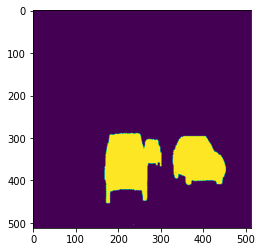

In [14]:
#Plot the image coresponding to the class car
plt.imshow(image_mask[:,:,5])

In [17]:
#Bring back the mask from 32 channels to the origianl 3 channels
img_class=[image_mask[:,:,i:i+1]*i for i in range(32)]
img_class = np.stack(img_class,axis=2)
img_class=np.sum(img_class,axis=2)
img=image_mask[:,:,0:3]
for j in range(512):
  for k in range(512):
    for l,i in enumerate(class_dict.values()):
      if (l==img_class[j,k,:])[0]:
         img[j,k,0:3]=i

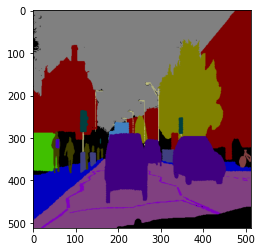

In [18]:
plt.imshow(img.astype('int'))

In [19]:
import imgaug.augmenters as iaa
aug2 = iaa.Fliplr(1)
aug3 = iaa.Emboss(alpha=1, strength=1)
aug4 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug5 = iaa.Sharpen(alpha=(1), lightness=(1.5))

In [20]:
train_data.head(2)

,image,mask
0,CamVid/train/0001TP_006690.png,CamVid/train_labels/0001TP_006690_L.png
1,CamVid/train/0001TP_006720.png,CamVid/train_labels/0001TP_006720_L.png


In [23]:
class Dataset_test:
    # we will be modifying this CLASSES according to your data/problems
    
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.png   file_name_L.png
    def __init__(self, data):
        
        # the paths of images
        self.images_fps   = list(data['image'].values)
        # the paths of segmentation images
        self.masks_fps    = list(data['mask'].values)
        #width 
        self.w = 512
        #heigth
        self.h = 512
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_NEAREST)
        image = image/255
        
        image_mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(image_mask,(512,512),interpolation=cv2.INTER_NEAREST)
        image_mask = cv2.cvtColor((image_mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

        image_masks = [np.sum((image_mask[:,:,:]==v).astype('float'),axis=-1)==3 for v in class_dict.values()]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)

class Dataset_train:
    # we will be modifying this CLASSES according to your data/problems
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.png   file_name_L.png
    def __init__(self, data):
        
        # the paths of images
        self.images_fps   = list(data['image'].values)
        # the paths of segmentation images
        self.masks_fps    = list(data['mask'].values)
        # giving labels for each class
        #self.class_values = [cls for cls in classes]
        #width 
        self.w = 512
        #heigth
        self.h = 512
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_NEAREST)
        image = image/255
       

        image_mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(image_mask,(512,512),interpolation=cv2.INTER_NEAREST)
        image_mask = cv2.cvtColor((image_mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

        image_masks = [np.sum((image_mask[:,:,:]==v).astype('float'),axis=-1)==3 for v in class_dict.values()]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        #Perform Image augmetation on train dataset 
        a = np.random.uniform()
        if a<0.1:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.2:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.3:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.4:
            image = aug5.augment_image(image)
            image_mask = aug5.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [24]:
train_dataset = Dataset_train(data=train_data)
test_dataset  = Dataset_test(data=test_data)

BATCH_SIZE=5
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
#Install Segmentation Models
!pip install segmentation_models

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model

In [26]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [27]:
from segmentation_models.losses import dice_loss

In [28]:
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')

#U-Net Artitechture with Restnet34 as backbone

In [29]:
model1 = Unet('resnet34', encoder_weights='imagenet', classes=32, activation='softmax', input_shape=(512,512,3),encoder_freeze=True)

In [30]:
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.001)

model1.compile(optimizer=optim, loss=dice_loss , metrics=[iou_score])

In [31]:
#Earlystop Callback Funtion to stop the training and save the model
class Earlystop(tf.keras.callbacks.Callback):
  def __init__(self,threshold):
    self.threshold=threshold

  def on_epoch_end(self,epoch,logs=None):
    accuracy=logs["val_iou_score"]
    if accuracy >=self.threshold:
      self.model.stop_training=True
      self.model.save('/content/drive/MyDrive/Colab/my_model_restnet34')

EarlyStop1=Earlystop(threshold=0.38)

In [32]:
history1 = model1.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=30,validation_data=test_dataloader,
                      callbacks=[EarlyStop1])

Epoch 1/30
120/120 [==============================] - 299s 2s/step - loss: 0.8998 - iou_score: 0.0755 - val_loss: 0.9806 - val_iou_score: 0.0103
Epoch 2/30
120/120 [==============================] - 290s 2s/step - loss: 0.8330 - iou_score: 0.1362 - val_loss: 0.9881 - val_iou_score: 0.0066
Epoch 3/30
120/120 [==============================] - 292s 2s/step - loss: 0.8146 - iou_score: 0.1533 - val_loss: 0.9870 - val_iou_score: 0.0078
Epoch 4/30
120/120 [==============================] - 294s 2s/step - loss: 0.7848 - iou_score: 0.1759 - val_loss: 0.9664 - val_iou_score: 0.0210
Epoch 5/30
120/120 [==============================] - 292s 2s/step - loss: 0.7619 - iou_score: 0.1959 - val_loss: 0.9445 - val_iou_score: 0.0350
Epoch 6/30
120/120 [==============================] - 293s 2s/step - loss: 0.7430 - iou_score: 0.2102 - val_loss: 0.8656 - val_iou_score: 0.0989
Epoch 7/30
120/120 [==============================] - 299s 2s/step - loss: 0.7361 - iou_score: 0.2138 - val_loss: 0.7827 - val_iou

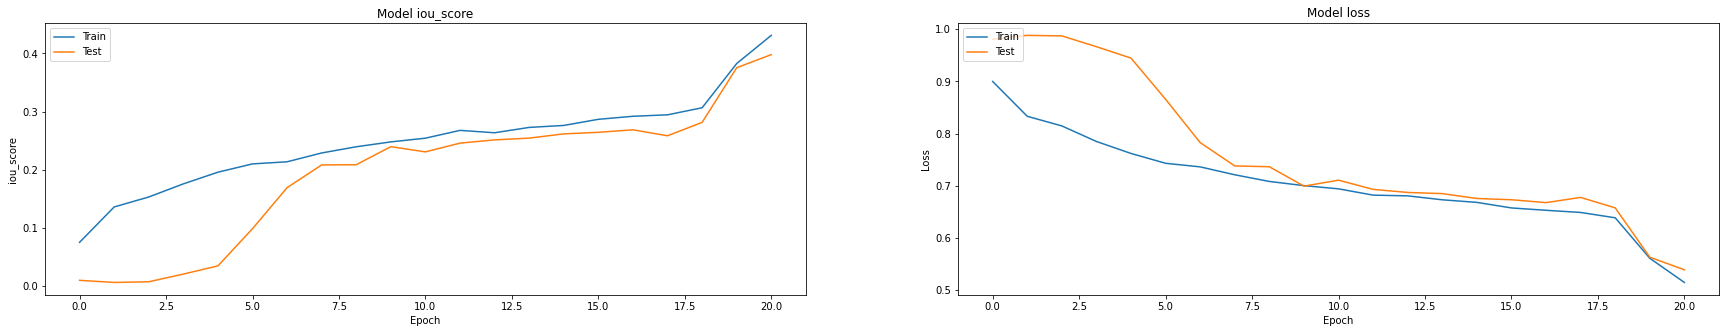

In [33]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history1.history['iou_score'])
plt.plot(history1.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

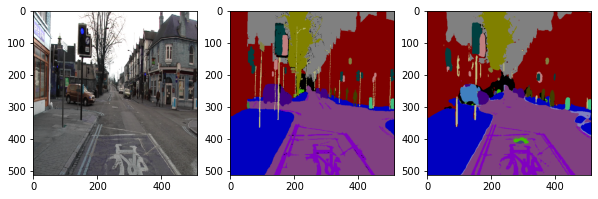

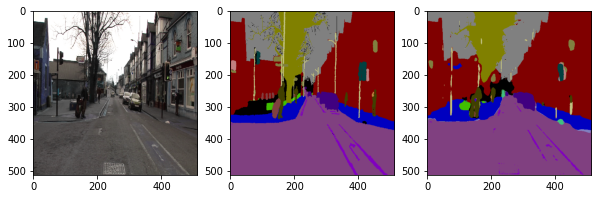

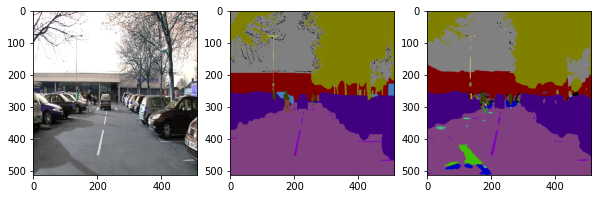

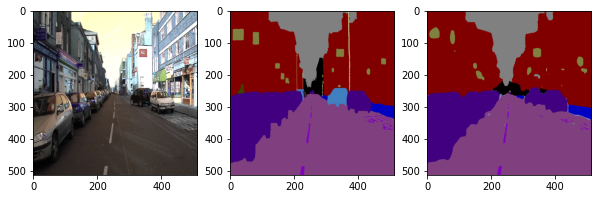

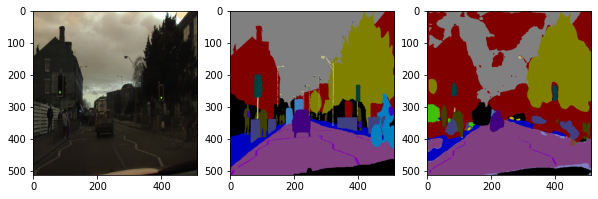

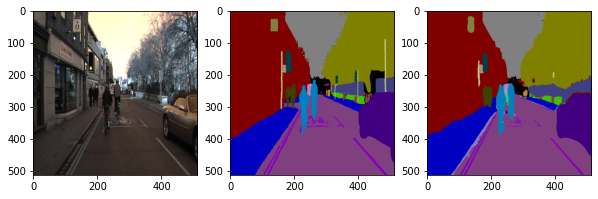

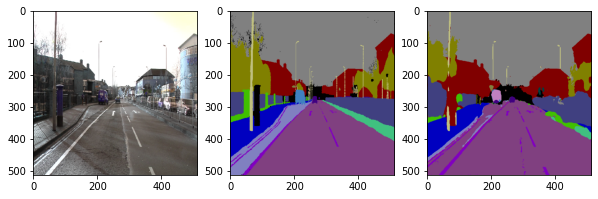

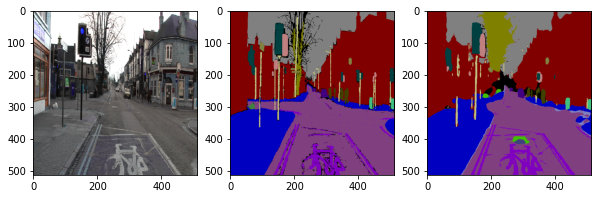

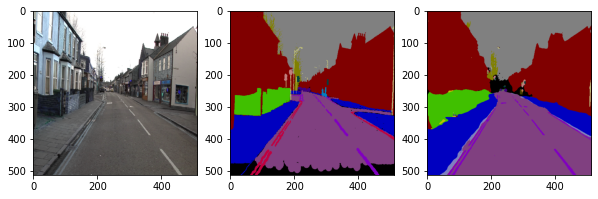

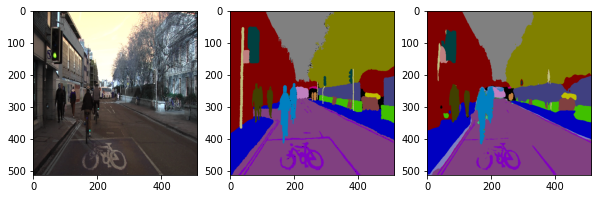

In [34]:
#Plotting the Real images, Mask and Predicted images
for i in np.random.randint(100, size=(10)):
  image = cv2.imread(test_data['image'].values[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512),interpolation=cv2.INTER_NEAREST)
  image = image/255

  image_mask = cv2.imread(test_data['mask'].values[i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (512,512),interpolation=cv2.INTER_NEAREST)
  image_mask = cv2.cvtColor((image_mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

  predicted  = model1.predict(image[np.newaxis,:,:,:])
  pre_max=np.amax(predicted,axis=3)
  pre_max=pre_max[:,:,:,np.newaxis]
  pre=[pre_max==predicted[:,:,:,i:i+1] for i in range(0,32)]
  pre = np.stack(pre, axis=3).astype('float')
  pre=np.squeeze(pre,axis=4)
  a=[pre[:,:,:,i:i+1]*i for i in range(32)]
  a = np.stack(a,axis=3)
  a=np.sum(a,axis=3)
  pre1=pre[:,:,:,0:3]
  for j in range(512):
    for k in range(512):
      for l,i in enumerate(class_dict.values()):
        if (l==a[0,j,k,:])[0]:
          pre1[0,j,k,0:3]=i

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.subplot(133)
  plt.imshow((pre1[0,:,:,:]).astype(np.uint8))

#U-Net Artitechture with VGG-16 as backbone

In [42]:
model2 = Unet('vgg16', encoder_weights='imagenet', classes=32, activation='softmax', input_shape=(512,512,3),encoder_freeze=True)

In [43]:
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.001)

model2.compile(optimizer=optim, loss=dice_loss , metrics=[iou_score])


In [44]:
#Earlystop Callback Funtion to stop the training and save the model
class Earlystop(tf.keras.callbacks.Callback):
  def __init__(self,threshold):
    self.threshold=threshold

  def on_epoch_end(self,epoch,logs=None):
    accuracy=logs["val_iou_score"]
    if accuracy >=self.threshold:
      self.model.stop_training=True
      self.model.save('/content/drive/MyDrive/Colab/my_model_vgg16')

EarlyStop2=Earlystop(threshold=0.42)

In [45]:
history2 = model2.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=60,validation_data=test_dataloader,
                      callbacks=[EarlyStop2])

Epoch 1/60
120/120 [==============================] - 296s 2s/step - loss: 0.9058 - iou_score: 0.0723 - val_loss: 0.8990 - val_iou_score: 0.0727
Epoch 2/60
120/120 [==============================] - 294s 2s/step - loss: 0.8417 - iou_score: 0.1301 - val_loss: 0.8444 - val_iou_score: 0.1242
Epoch 3/60
120/120 [==============================] - 293s 2s/step - loss: 0.8048 - iou_score: 0.1606 - val_loss: 0.7955 - val_iou_score: 0.1630
Epoch 4/60
120/120 [==============================] - 290s 2s/step - loss: 0.7787 - iou_score: 0.1797 - val_loss: 0.7669 - val_iou_score: 0.1844
Epoch 5/60
120/120 [==============================] - 294s 2s/step - loss: 0.7603 - iou_score: 0.1940 - val_loss: 0.7459 - val_iou_score: 0.2003
Epoch 6/60
120/120 [==============================] - 299s 2s/step - loss: 0.7433 - iou_score: 0.2091 - val_loss: 0.7303 - val_iou_score: 0.2146
Epoch 7/60
120/120 [==============================] - 317s 3s/step - loss: 0.7332 - iou_score: 0.2158 - val_loss: 0.7188 - val_iou

In [ ]:
model2.save('/content/drive/MyDrive/Colab/my_model_VGG16')

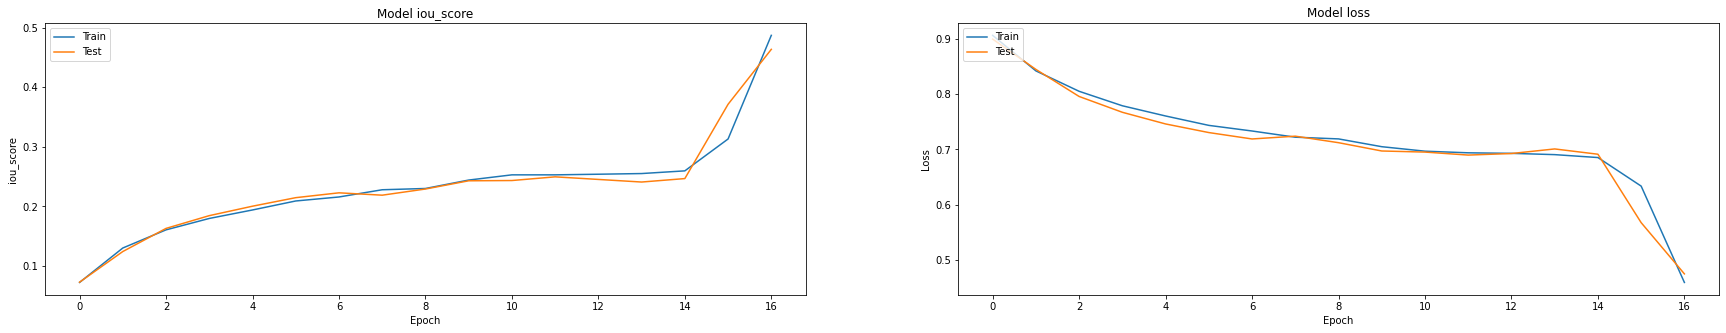

In [46]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history2.history['iou_score'])
plt.plot(history2.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

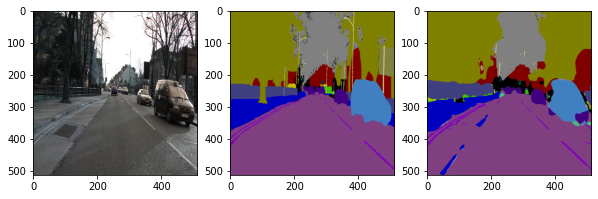

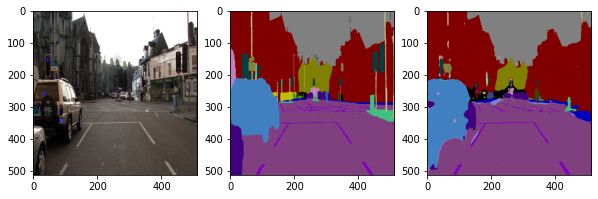

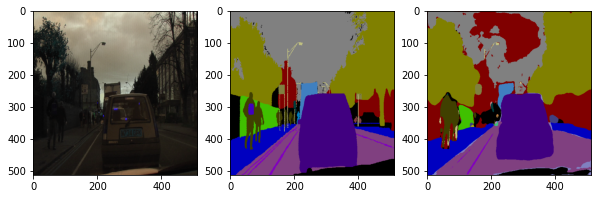

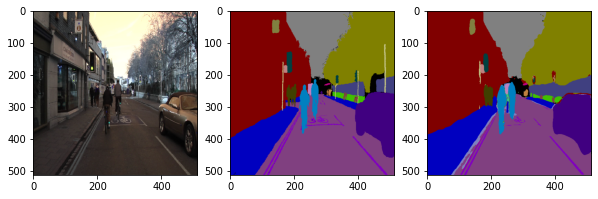

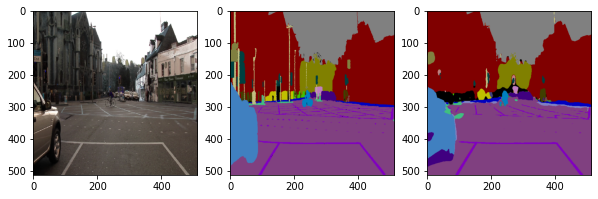

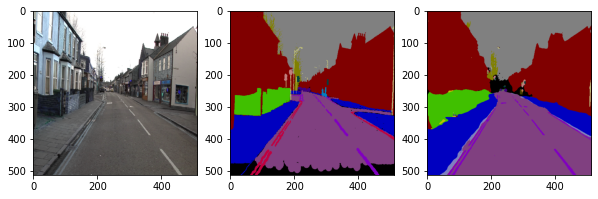

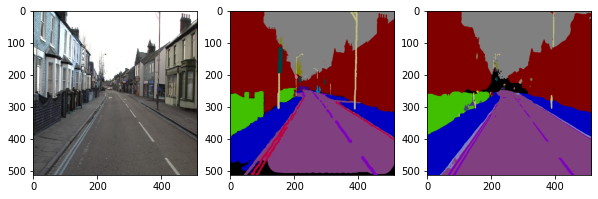

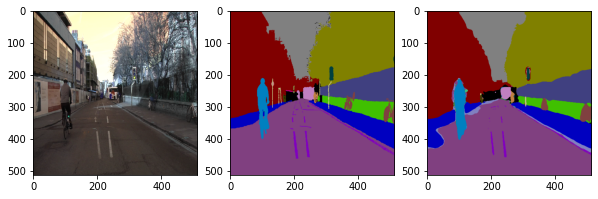

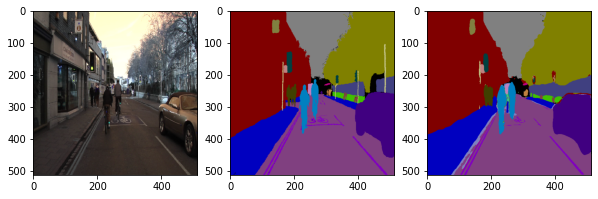

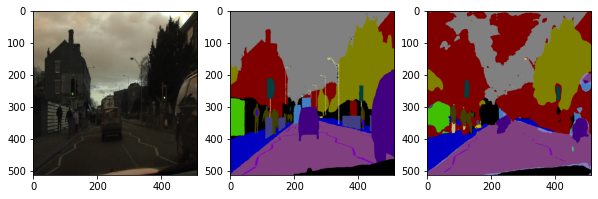

In [48]:
#Plotting the Real images, Mask and Predicted images
for i in np.random.randint(100, size=(10)):
  image = cv2.imread(test_data['image'].values[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image,(512,512),interpolation=cv2.INTER_NEAREST)
  image = image/255

  image_mask = cv2.imread(test_data['mask'].values[i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask,(512,512),interpolation=cv2.INTER_NEAREST)
  image_mask = cv2.cvtColor((image_mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

  predicted  = model1.predict(image[np.newaxis,:,:,:])
  pre_max=np.amax(predicted,axis=3)
  pre_max=pre_max[:,:,:,np.newaxis]
  pre=[pre_max==predicted[:,:,:,i:i+1] for i in range(0,32)]
  pre = np.stack(pre, axis=3).astype('float')
  pre=np.squeeze(pre,axis=4)
  a=[pre[:,:,:,i:i+1]*i for i in range(32)]
  a = np.stack(a,axis=3)
  a=np.sum(a,axis=3)
  pre1=pre[:,:,:,0:3]
  for j in range(512):
    for k in range(512):
      for l,i in enumerate(class_dict.values()):
        if (l==a[0,j,k,:])[0]:
          pre1[0,j,k,0:3]=i

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.subplot(133)
  plt.imshow((pre1[0,:,:,:]).astype(np.uint8))

#From the predicted mask above plots for Restnet34 model and VGG16 model we can see that Restnet 34 has given better image segmentation results for this dataset.